In [1]:
%config Completer.use_jedi = False # in case your autocomplete does not work

I mentioned about logging in the previous article, but we only displayed it in the Tensorboard.
Now, can we pick up what we have left previously? Why not?

# Checkpoint loading

The checkpoints are stored in:

In [2]:
! tree lightning_logs/

lightning_logs/
├── version_0
│   ├── checkpoints
│   │   └── epoch=9-step=5500.ckpt
│   ├── events.out.tfevents.1654332948.ubuntu-OMEN.110229.0
│   ├── events.out.tfevents.1654332989.ubuntu-OMEN.110229.1
│   └── hparams.yaml
├── version_1
│   ├── checkpoints
│   │   └── epoch=9-step=5500.ckpt
│   ├── events.out.tfevents.1654332995.ubuntu-OMEN.110229.2
│   ├── events.out.tfevents.1654333035.ubuntu-OMEN.110229.3
│   └── hparams.yaml
├── version_2
│   ├── checkpoints
│   │   └── epoch=9-step=5500.ckpt
│   ├── events.out.tfevents.1654333539.ubuntu-OMEN.115365.0
│   ├── events.out.tfevents.1654333578.ubuntu-OMEN.115365.1
│   └── hparams.yaml
└── version_3
    ├── checkpoints
    │   └── epoch=9-step=5500.ckpt
    ├── events.out.tfevents.1654333584.ubuntu-OMEN.115365.2
    ├── events.out.tfevents.1654333632.ubuntu-OMEN.115365.3
    └── hparams.yaml

8 directories, 16 files


In [3]:
# 1. Import

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pytorch_lightning as pl # --> NEW
from torchvision import datasets, transforms
from torchmetrics.functional import accuracy
# from pytorch_lightning.metrics.functional import accuracy # --> This is NEW
from torch.utils.data import DataLoader, random_split # random_split is NEW

import sps # from https://github.com/IssamLaradji/sps --> a new optimizer

# 2. Copy the model here

class FNN(pl.LightningModule):
    
    def __init__(self, input_size, num_neurons_hidden1,  num_neurons_hidden2, output_size, optimizer='adam'):
        # Copy paste from the previous article
        super().__init__()
        self.input_layer = nn.Linear(input_size,num_neurons_hidden1)
        self.hidden_layer1 = nn.Linear(num_neurons_hidden1,num_neurons_hidden2)
        self.output_layer = nn.Linear(num_neurons_hidden2,output_size)
        
        tf_resize = transforms.Resize((28,28)) # make sure that all loaded images have these dimensions
        tf_totensor = transforms.ToTensor() # Why? pytorch uses this datatype
        tf_normalize = transforms.Normalize(mean=(.5,),std=(.5,)) # this is rather tricky to explain. I'll explain it after we compose all these transformations

        self.tf_compose = transforms.Compose([tf_resize,tf_totensor,tf_normalize])
        
        self.optimizer = optimizer
        
    def forward(self,x):
        # Copy paste from the previous article
        y = nn.functional.relu(self.input_layer(x))
        y = nn.functional.relu(self.hidden_layer1(y))
        y = self.output_layer(y)
        return y
    
    def training_step(self, batch, batch_idx):
        # Copy paste from the previous article
        inputs, labels = batch
        inputs = inputs.view(inputs.shape[0],-1)
        
        outputs = self.forward(inputs)
        loss = nn.functional.cross_entropy(outputs,labels) # --> NEW. Using nn.CrossEntropyLoss
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        # This is new, but the structure is the same as training_step
        inputs, labels = batch
        inputs = inputs.view(inputs.shape[0],-1)
        
        outputs = self.forward(inputs)
        loss = nn.functional.cross_entropy(outputs,labels)
        
        preds = torch.argmax(outputs, dim=1)
        acc = accuracy(preds, labels) # --> NEW
        
        # Calling self.log will surface up scalars for you in TensorBoard
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        
        return loss
    
    def test_step(self, batch, batch_idx):
        # This is new, but the structure is the same as test_step
        # but I replace val_loss --> test_loss etc
        inputs, labels = batch
        inputs = inputs.view(inputs.shape[0],-1)
        
        outputs = self.forward(inputs)
        loss = nn.functional.cross_entropy(outputs,labels)
        
        preds = torch.argmax(outputs, dim=1)
        acc = accuracy(preds, labels)
        
        # Calling self.log will surface up scalars for you in TensorBoard
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', acc, prog_bar=True)
        
        return loss
    
    def configure_optimizers(self):
        if self.optimizer == 'sps':
            optimizer = sps.Sps(self.parameters()) # No learning rate to be set :D
        else:
            optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
    
    ####################
    # DATA RELATED HOOKS
    ####################

    def prepare_data(self):
        # download once
        datasets.MNIST(root='./', train=True, download=True)
        datasets.MNIST(root='./', train=False, download=True)
    
    def setup(self, stage=None):
        # split, transform, secretly move to GPU (if needed) by PL (not by us)
        if stage == 'fit' or stage is None:
            mnist_full = datasets.MNIST(root='./', train=True, transform=self.tf_compose)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])
            
        if stage == 'fit' or stage is None:
            self.mnist_test = datasets.MNIST(root='./', train=False, transform=self.tf_compose)
            
    def train_dataloader(self): 
        return DataLoader(self.mnist_train, batch_size=100, num_workers=2)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=100, num_workers=2)
    
    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=100, num_workers=2)

In [4]:
# 3. Load from checkpoint

model = FNN.load_from_checkpoint(
    checkpoint_path='./lightning_logs/version_0/checkpoints/epoch=9-step=5500.ckpt',
    input_size=784,
    num_neurons_hidden1=100,
    num_neurons_hidden2=50,
    output_size=10
) # version 0 is my Adam implementation


# Inference

After loading the model, we can perform, for example, inference as follows.

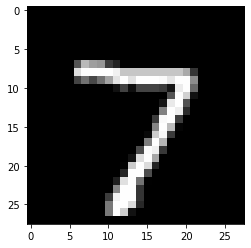

In [5]:
iterator = iter(
    DataLoader(datasets.MNIST(root='./', train=False, download=True, transform=model.tf_compose),
               batch_size=1
              )
)
image = next(iterator)
image = image[0][0]
plt.imshow(image.numpy().transpose(1,2,0),cmap='gray')

In [6]:
model.forward(image.view(image.size(0),-1)).argmax()

tensor(7)

# Continue Training

We can also contine training

In [7]:
try:
    trainer = pl.Trainer(gpus=1,max_epochs=1)
except Exception as e:
    # most likely due to GPU, so fallback to non GPU
    print(e)
    trainer = pl.Trainer(max_epochs=1)
    
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type   | Params
-----------------------------------------
0 | input_layer   | Linear | 78.5 K
1 | hidden_layer1 | Linear | 5.0 K 
2 | output_layer  | Linear | 510   
-----------------------------------------
84.1 K    Trainable params
0         Non-trainable params
84.1 K    Total params
0.336     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/ardimas/miniconda3/envs/pytorch_tutorial/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/ardimas/miniconda3/envs/pytorch_tutorial/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from to

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [8]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

Reusing TensorBoard on port 6006 (pid 111424), started 0:21:41 ago. (Use '!kill 111424' to kill it.)

In [9]:
trainer.test()

/home/ardimas/miniconda3/envs/pytorch_tutorial/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1446: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `test(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.checkpoint_callback.last_model_path` to use the last model.
  rank_zero_warn(
Restoring states from the checkpoint path at /home/ardimas/Documents/PROJECTS/pytorch_cv/lightning_logs/version_4/checkpoints/epoch=0-step=550.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/ardimas/Documents/PROJECTS/pytorch_cv/lightning_logs/version_4/checkpoints/epoch=0-step=550.ckpt
/home/ardimas/miniconda3/envs/pytorch_tutorial/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a b

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9678000211715698
        test_loss           0.1038515716791153
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.1038515716791153, 'test_acc': 0.9678000211715698}]

Notice that the validation and test accuracy are already good even the number of epochs is only one